"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[41]
[  0  41 100]
[0.67242919 0.30077322]


Text(0, 0.5, 'Firing Rate')

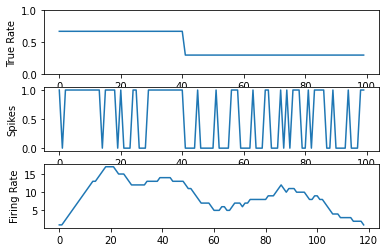

In [26]:
# Some poisson spiking
length = 100
states = 2
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random(states)

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
data_vec = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(3,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(data_vec)
ax[2].plot(np.convolve(data_vec,np.ones(20)))
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")
ax[2].set_ylabel("Firing Rate")

In [27]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)])
print(mean_vals)

[0.66 0.42]


In [104]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

with pm.Model() as model:
    sig_b = pm.Cauchy('sig_b', 0,5, testval = 2)
    #sig_b = pm.HalfCauchy('sig_b', 2, testval = 0.1)
    
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = states,
                                  testval = mean_vals + 1e-3)

    #a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    #b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    #tau_latent = pm.Beta('tau_latent', a, b, 
    tau_latent = pm.Beta('tau_latent', 2, 5, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [105]:
with model:
    weight_stack = var_sig_exp_tt(idx[np.newaxis,:]-tau[:,np.newaxis],sig_b)
    #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    lambda_ = pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0)

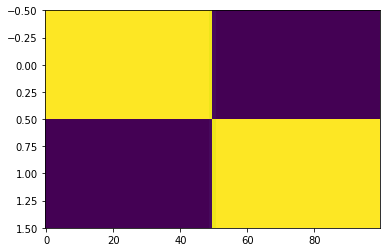

In [106]:
plt.imshow(weight_stack.tag.test_value,aspect='auto')

(100,)


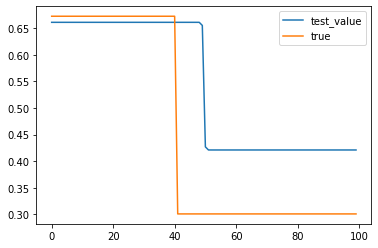

In [107]:
plt.plot(lambda_.tag.test_value,label='test_value')
plt.plot(true_r,label='true')
plt.legend()
print(lambda_.tag.test_value.shape)

In [108]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

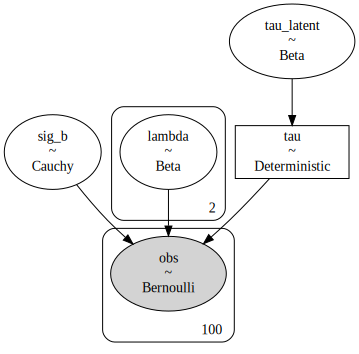

In [109]:
pm.model_to_graphviz(model)

In [110]:
with model:
    inference = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
            mean=inference.approx.mean.eval,  # callable that returns mean
            std=inference.approx.std.eval,  # callable that returns std
        )
    approx = pm.fit(n=fit, method=inference,
                   callbacks=[tracker])
    trace = approx.sample(draws=samples)

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sig_b`.ravel()[0] is NaN.
The current approximation of RV `tau_latent_logodds__`.ravel()[0] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[0] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[1] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [111]:
inference.approx.mean.eval()

array([nan, nan, nan, nan])

In [112]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])
tracker_mean.shape

(8, 4)

No handles with labels found to put in legend.


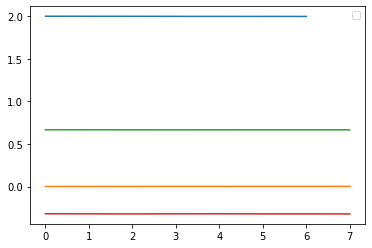

In [113]:
plt.plot(tracker_mean);plt.legend();

No handles with labels found to put in legend.


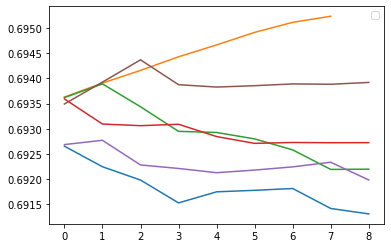

In [37]:
plt.plot(tracker_std);plt.legend();

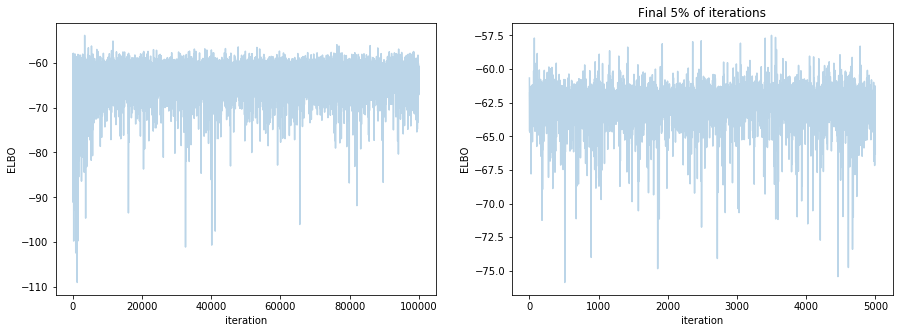

In [177]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [178]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:01<00:00, 1430.31it/s]


Text(0.5, 1.0, 'Mean prediction')

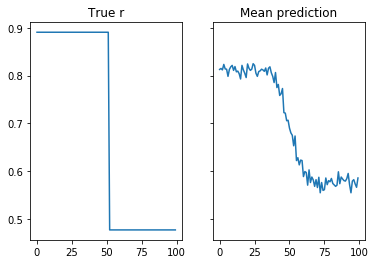

In [179]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
ax[1].plot(np.mean(ppc['obs'],axis=0), alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [180]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 1)


array([50])

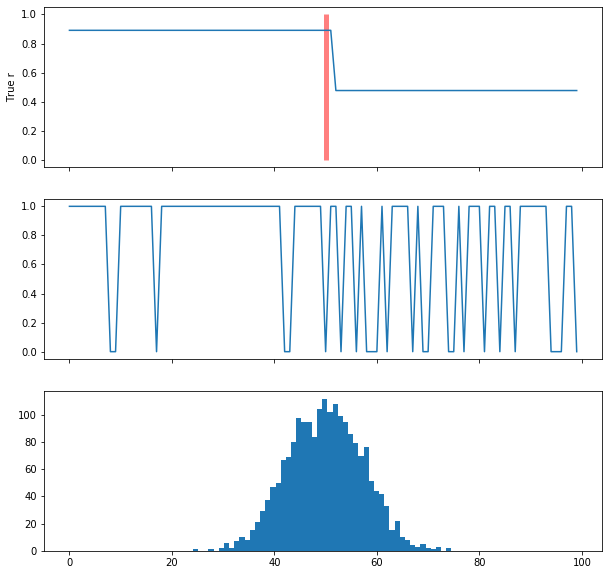

In [181]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].plot(true_r)
ax[0].set_ylabel('True r')
ax[1].plot(data_vec)
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[0].vlines(mode_tau[tau_num],0,1,color='red',alpha=0.5,linewidth=5)
